# General Book Recommendations 

### Popularity-based Filtering
Offer generalized recommendations to each user, based on popularity and high rating. This is a basic method, which is built on the vision that more popular and critically acclaimed books will have a higher probability of being liked by the average audience.

### Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Visualization enhancement
Adjust plots size for better visualization experience.

#### Increase the size of plots to be able to see detailed visualizations clear

In [2]:
plt.rcParams["figure.figsize"] = [25, 10]
plt.rcParams.update({'font.size': 24})

### Dataset

In [3]:
unq_books = pd.read_csv('UniqueBooks.csv', error_bad_lines=False, delimiter=',', encoding = 'ISO-8859-1') 
unq_books

,Book-Title,Year-Of-Publication,Book-Author,AVG-Rating,Publisher,Vote-Count,ISBN
0,Flesh Tones: A Novel,2002,M. J. Rose,6.285714,Ballantine Books,28,034545104X
1,Rites of Passage,2001,Judith Rae,4.800000,Heinle,5,0571117880
2,The Notebook,1996,Nicholas Sparks,7.897611,Warner Books,293,0446605239
3,Help!: Level 1,1999,Philip Prowse,3.000000,Cambridge University Press,1,052165615X
4,The Amsterdam Connection : Level 4 (Cambridge ...,2001,Sue Leather,6.000000,Cambridge University Press,1,0521795028
...,...,...,...,...,...,...,...
118716,A MARRIAGE MADE AT WOODSTOCK,1995,Cathie Pelletier,7.000000,Washington Square Press,1,0671516949
118717,The WEIGHT OF WINTER,1993,Cathie Pelletier,9.000000,Washington Square Press,1,067179387X
118718,Time Out Chicago (Time Out Chicago),2000,Time Out,9.000000,Penguin Books,1,0140290788
118719,The Zen of Proposal Writing: An Expert's Stres...,2002,Kitta Reeds,7.000000,Three Rivers Press (CA),1,0609806491


In order to do this kind of filtering, the following tasks must be completed:
* Find a metric to score or rate book;
* Calculate the score for every book;
* Sort the scores and recommend the best rated books to the readers.

There is already a metric in the table which provides a rate of the book - attribute "AVG-Rating". Nevertheless, using it would not be fair enough since a book with 8.9 average rating and only 3 votes cannot be considered better than the book with 7.8 as as average rating but 40 votes. To optimise rating, IMDB's weighted rating formula will be used. It looks like this:
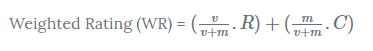

where,

* v is the number of votes for the book = Vote-Count;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the book = AVG-Rating; 
* C is the mean vote across the whole report = AVG-Rating.MEAN().

Each row in the dataset contains a unique book and its rating information.

*Count C*

In [4]:
C= unq_books['AVG-Rating'].mean()
C

7.572258912926201

The mean rating for all the books is **7.6 on a scale of 10**.

*Count M*

The value for *m* is left to be determined. Check statistics for the votes count of the books in the dataset to get a decision about the percentile that will be included in the filtering:

In [5]:
unq_books['Vote-Count'].describe()

count    118721.000000
mean          3.068252
std           9.724439
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: Vote-Count, dtype: float64

>The **average votes count** is **~3**
><br>**75%** of the books **have lower votes count than the mean**
><br>The **maximum votes count** is **707**

Based on the statistics, a very high percentile has to be used for the popularity-based filtering, as there is a huge difference between the amount of votes count at the 75th percentile and the maximum vote. Observe the case of using the starting value of 90th percentile as a cutoff:

In [6]:
m= unq_books['Vote-Count'].quantile(0.9)
m

5.0

At least 5 votes are required for a book to be included in the chart. This value is higher than the average.

In [7]:
pop_books = unq_books.copy().loc[(unq_books['Vote-Count'] >= m) & (unq_books['AVG-Rating'] > C)]
pop_books.shape

(7600, 7)

There are 7 600 books which qualify to be in this list. Considering the fact that these are 6% of the books, there would be a great variety of suitable books. However, the least amount of readers that approved these books is 5, which is insignificant regarding the total count of unique users - 65 390.

Apply the same actions to the 95th percentile to check whether it would be a more suitable decision regarding popularity:

In [8]:
m= unq_books['Vote-Count'].quantile(0.95)
m

9.0

At least 9 votes are required for a book to be included in the chart. This value is even higher than the average compared to the previous case, which is a good indicator.

In [9]:
pop_books = unq_books.copy().loc[(unq_books['Vote-Count'] >= m) & (unq_books['AVG-Rating'] > C)]
pop_books.shape

(3756, 7)

There are 3 756 books which qualify to be in this list. Considering the fact that these are 3% of the books, there would still be a great variety of suitable books. However, the least amount of readers that approved these books is 9, which is better yet again insignificant regarding the total count of unique users - 65 390.

It seems that a small proportion of the books must have notable user popularity. Check whether the 99th percentile contains notable votes count compared to the total amont of readers in the system:

In [10]:
m= unq_books['Vote-Count'].quantile(0.99)
m

32.0

In [11]:
pop_books = unq_books.copy().loc[(unq_books['Vote-Count'] >= m) & (unq_books['AVG-Rating'] > C)]
pop_books.shape

(785, 7)

In this case, there is a significant difference in terms of users compared to the 95th percentile. The variety of books (785) falls down below 1%, but the filtering would be more accurate in terms of user approval due to the following fact:
>*A book must have more votes than at least 99% of the books in the list to feature in the charts.*

The value for 'm' is determined - **99th percentile will be used as a cutoff**. 

Now, everything is prepared to calculate the metric for each qualified book. To do this, a function, weighted_rating() will be defined, which calculates the formula and gets the score as the metric.

In [12]:
def weighted_rating(unq_books, m=m, C=C):
    v = unq_books['Vote-Count']
    R = unq_books['AVG-Rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

Define a new feature 'score' and calculate its value with `weighted_rating()`:

In [13]:
pop_books['score'] = pop_books.apply(weighted_rating, axis=1)

Finally, sort the DataFrame based on the score feature and output the title, author(s), vote count, average rating and weighted rating or score of the top 10 books.

In [14]:
#Sort books based on score calculated above
pop_books = pop_books.sort_values('score', ascending=False)

#Print the top 10 books
pop_books[['Book-Title', 'Book-Author', 'Vote-Count', 'AVG-Rating', 'score']].head(10)

,Book-Title,Book-Author,Vote-Count,AVG-Rating,score
5067,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,134,9.320896,8.983809
2763,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,247,9.125506,8.947356
1071,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,277,9.043321,8.890978
41,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,211,9.047393,8.853137
6827,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,102,9.254902,8.853077
1072,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,176,9.062500,8.833232
368,To Kill a Mockingbird,Harper Lee,267,8.977528,8.827131
353,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,315,8.936508,8.810698
298,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,326,8.840491,8.727129
2690,The Fellowship of the Ring (The Lord of the Ri...,J. R. R. Tolkien,204,8.901961,8.721662


First recommender is ready.

Text(0.5, 1.0, 'Top Popular Books')

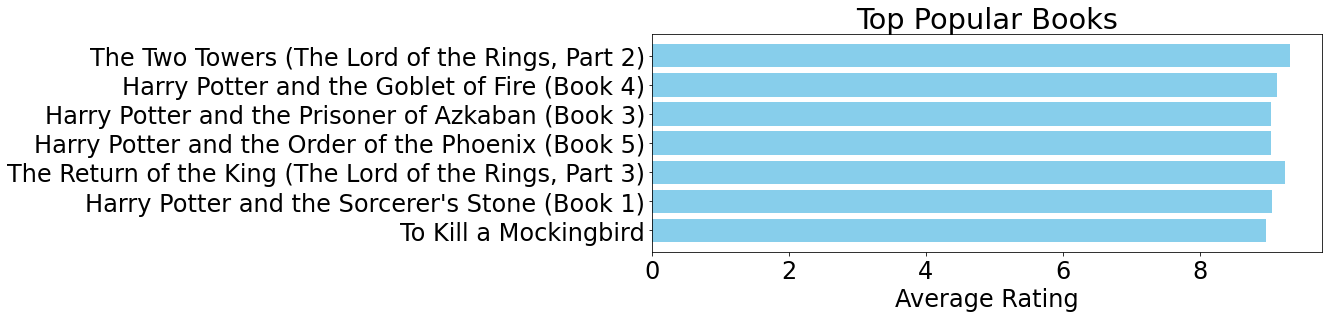

In [15]:
plt.figure(figsize=(12,4))

plt.barh(pop_books['Book-Title'].head(7),pop_books['AVG-Rating'].head(7), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Average Rating")
plt.title("Top Popular Books")

This popularity-based recommender provides a general chart of recommended books to all the users. The suggestions are not sensitive to the interests and tastes of a particular reader. 

---------------

#### Save the extracted dataset with popular books for further usage in modeling

In [16]:
pop_books.to_csv('PopularBooks.csv', index = False)